<a href="https://colab.research.google.com/github/ZEY0D/schiesser-antibody-modeling/blob/main/Machine_Learning_PINN_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [9]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Parameters Decleration from the reference

In [10]:
# Parameters
kf = 1.0e5         # Forward rate constant
kr = 1.0e1        # Reverse rate constant
cb_sat = 1.66e-9   # Saturation concentration
D = 1e-10           # Diffusion coefficient
L = 5.0e-5         # Domain length
T = 100.0          # Final time
cbulk = 4.48e-5

# Collocation, boundary, and initial condition points
N_f, N_b, N_ic = 10000, 200, 200

Inputs normalization

In [11]:
normalize_z = lambda z: z / L
normalize_t = lambda t: t / T

def rescale_c(c): return c * cbulk
def rescale_theta(th): return th * 0.295

# range control
def clamp01(x): return torch.clamp(x, 0.0, 1.0)

Neural Networks initilization

In [24]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, z, t):
        z_n = normalize_z(z)
        t_n = normalize_t(t)
        input = torch.cat([z_n, t_n], dim=1)
        return cbulk * self.net(input)


class ThetaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        t_n = normalize_t(t)
        return 0.295 * torch.sigmoid(self.net(t_n))


In [25]:
model_c = PINN().to(device)
model_theta = ThetaNet().to(device)

Training data

In [26]:
z_f = torch.rand(N_f, 1).to(device) * L
t_f = torch.rand(N_f, 1).to(device) * (T - 1.0) + 1.0

z0 = torch.zeros(N_b, 1).to(device)
zL = torch.ones(N_b, 1).to(device) * L
t_b = torch.linspace(0, T, N_b).view(-1, 1).to(device)

# using adam optimizer
optimizer = torch.optim.Adam(list(model_c.parameters()) + list(model_theta.parameters()), lr=1e-3)


Function to calculate the total loss depending on physics

In [31]:
def loss_fn():
    z_f_, t_f_ = z_f.clone().detach().requires_grad_(True), t_f.clone().detach().requires_grad_(True)
    c = model_c(z_f_, t_f_)

    # PDE residual: ∂c/∂t - D ∂²c/∂z² = 0
    c_z = autograd.grad(c, z_f_, grad_outputs=torch.ones_like(c), retain_graph=True, create_graph=True)[0]
    c_zz = autograd.grad(c_z, z_f_, grad_outputs=torch.ones_like(c_z), retain_graph=True, create_graph=True)[0]
    c_t = autograd.grad(c, t_f_, grad_outputs=torch.ones_like(c), retain_graph=True, create_graph=True)[0]
    pde_res = c_t - D * c_zz

    # Boundary at z = L
    cL = model_c(zL, t_b)
    cL_target = torch.full_like(cL, cbulk)
    loss_bc_L = torch.mean((cL - cL_target) ** 2)

    # Boundary at z = 0: Dirichlet c = 0.00043
    c0 = model_c(z0, t_b)
    c0_target = torch.full_like(c0, 0.00043)
    loss_bc_0 = torch.mean((c0 - c0_target) ** 2)

    # Theta dynamics (ODE)
    t_b_ = t_b.clone().detach().requires_grad_(True)
    theta = model_theta(t_b_)
    dtheta_dt = autograd.grad(theta, t_b_, grad_outputs=torch.ones_like(theta), create_graph=True)[0]

    # Reaction rate with normalized cb_sat
    cb_sat = 0.295
    reaction_rate = kf * c0 * (1 - theta / cb_sat) - kr * theta / cb_sat
    ode_res = dtheta_dt - reaction_rate
    loss_ode = torch.mean(ode_res**2)

    # Terminal constraint on theta(T)
    theta_final = model_theta(torch.tensor([[T]]).float().to(device))
    theta_target = torch.tensor([[0.295]]).float().to(device)
    loss_terminal = torch.mean((theta_final - theta_target) ** 2)

    # PDE Loss
    loss_pde = torch.mean(pde_res**2)

    # Total weighted loss
    total_loss = (
        loss_pde
        + 10.0 * loss_bc_L
        + 10.0 * loss_bc_0
        + loss_ode
        + 10.0 * loss_terminal
    )

    return total_loss, loss_pde.item(), loss_bc_L.item(), loss_bc_0.item(), loss_ode.item()



# def loss_fn():
#     z_f_, t_f_ = z_f.clone().detach().requires_grad_(True), t_f.clone().detach().requires_grad_(True)
#     c = model_c(z_f_, t_f_)
#     c_z = autograd.grad(c, z_f_, grad_outputs=torch.ones_like(c), retain_graph=True, create_graph=True)[0]
#     c_zz = autograd.grad(c_z, z_f_, grad_outputs=torch.ones_like(c_z), retain_graph=True, create_graph=True)[0]
#     c_t = autograd.grad(c, t_f_, grad_outputs=torch.ones_like(c), retain_graph=True, create_graph=True)[0]
#     pde_res = c_t - D * c_zz

#     # Boundary at z=L
#     cL = model_c(zL, t_b)
#     cL_target = torch.full_like(cL, cbulk)

#     # Theta dynamics
#     t_b_ = t_b.clone().detach().requires_grad_(True)
#     theta = model_theta(t_b_)
#     dtheta_dt = autograd.grad(theta, t_b_, grad_outputs=torch.ones_like(theta), create_graph=True)[0]
#     c0 = model_c(z0, t_b_)
#     reaction_rate = kf * c0 * (1 - theta / 0.295) - kr * theta / 0.295
#     ode_res = dtheta_dt - reaction_rate
#     # Terminal loss
#     theta_final = model_theta(torch.tensor([[T]]).float().to(device))
#     theta_target = torch.tensor([[0.295]]).float().to(device)
#     loss_terminal = torch.mean((theta_final - theta_target) ** 2)

#     # Total loss
#     loss_pde = torch.mean(pde_res**2)
#     loss_bc = torch.mean((cL - cL_target)**2)
#     loss_ode = torch.mean(ode_res**2)

#     total_loss = loss_pde + loss_bc + loss_ode + 10.0 * loss_terminal
#     return total_loss, loss_pde.item(), loss_bc.item(), loss_ode.item(), loss_terminal.item()


Getting into the training loop on 5000 epoch

In [32]:
for epoch in range(5001):
    optimizer.zero_grad()
    loss_total, l_pde, l_bc, l_ode, l_term = loss_fn()
    loss_total.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_total.item():.3e} | PDE: {l_pde:.2e}, BC: {l_bc:.2e}, ODE: {l_ode:.2e}, Term: {l_term:.2e}")


Epoch 0, Loss: 1.283e-02 | PDE: 2.79e-09, BC: 2.52e-08, ODE: 5.60e-08, Term: 4.05e-05
Epoch 100, Loss: 1.273e-02 | PDE: 3.66e-09, BC: 1.90e-08, ODE: 5.99e-08, Term: 1.60e-04
Epoch 200, Loss: 1.233e-02 | PDE: 4.35e-09, BC: 1.54e-08, ODE: 6.39e-08, Term: 3.94e-05
Epoch 300, Loss: 1.208e-02 | PDE: 4.96e-09, BC: 1.30e-08, ODE: 6.81e-08, Term: 3.89e-05
Epoch 400, Loss: 1.779e-02 | PDE: 5.53e-09, BC: 1.13e-08, ODE: 7.27e-08, Term: 5.83e-03
Epoch 500, Loss: 1.161e-02 | PDE: 6.04e-09, BC: 9.97e-09, ODE: 7.68e-08, Term: 3.72e-05
Epoch 600, Loss: 1.139e-02 | PDE: 6.54e-09, BC: 8.91e-09, ODE: 8.13e-08, Term: 3.73e-05
Epoch 700, Loss: 1.117e-02 | PDE: 7.02e-09, BC: 8.05e-09, ODE: 8.61e-08, Term: 3.67e-05
Epoch 800, Loss: 1.097e-02 | PDE: 7.47e-09, BC: 7.34e-09, ODE: 9.08e-08, Term: 3.67e-05
Epoch 900, Loss: 1.077e-02 | PDE: 7.92e-09, BC: 6.73e-09, ODE: 9.57e-08, Term: 3.58e-05
Epoch 1000, Loss: 1.057e-02 | PDE: 8.35e-09, BC: 6.22e-09, ODE: 1.01e-07, Term: 3.51e-05
Epoch 1100, Loss: 1.042e-02 | PDE

Model evaluation

In [29]:
# Evaluation
model_c.eval()
model_theta.eval()

# Grids
t_eval = torch.linspace(0, T, 200).view(-1, 1).to(device)
z_eval = torch.linspace(0, L, 200).view(-1, 1).to(device)
T_grid, Z_grid = torch.meshgrid(t_eval.squeeze(), z_eval.squeeze(), indexing='ij')
t_flat, z_flat = T_grid.reshape(-1, 1), Z_grid.reshape(-1, 1)

# Predict full c(z,t)
with torch.no_grad():
    c_pred_flat = model_c(z_flat, t_flat)
    c_pred = c_pred_flat.view(200, 200).cpu().numpy()

# Evaluate boundary values
z0_eval = torch.zeros_like(t_eval).to(device)
with torch.no_grad():
    c0 = model_c(z0_eval, t_eval).cpu().numpy().flatten()
    theta = model_theta(t_eval).cpu().numpy().flatten()
    cb = theta * cb_sat
    rate = (kf * c0 * (1 - theta / 0.295) - kr * theta / 0.295)


Plotting solutions' graphs like in the reference side y side

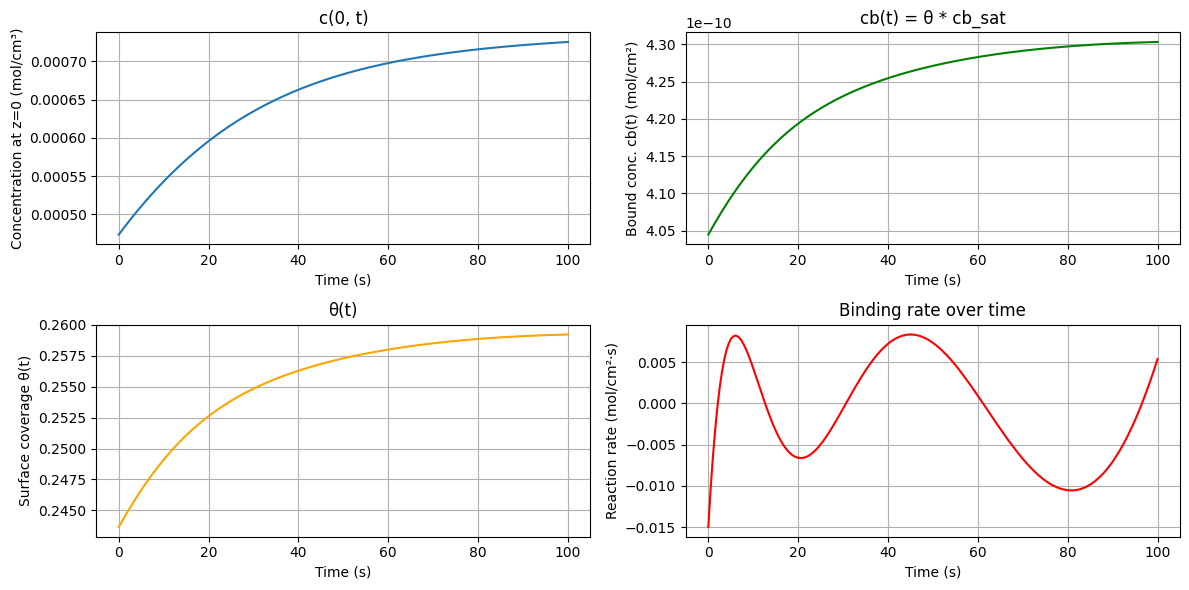

In [33]:
# Plot c(0, t)
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(t_eval.cpu(), c0, label="c(0, t)")
plt.xlabel("Time (s)")
plt.ylabel("Concentration at z=0 (mol/cm³)")
plt.title("c(0, t)")
plt.grid(True)

# Plot cb(t)
plt.subplot(2, 2, 2)
plt.plot(t_eval.cpu(), cb, label="cb(t)", color='green')
plt.xlabel("Time (s)")
plt.ylabel("Bound conc. cb(t) (mol/cm²)")
plt.title("cb(t) = θ * cb_sat")
plt.grid(True)

# Plot θ(t)
plt.subplot(2, 2, 3)
plt.plot(t_eval.cpu(), theta, label="θ(t)", color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Surface coverage θ(t)")
plt.title("θ(t)")
plt.grid(True)

# Plot rate(t)
plt.subplot(2, 2, 4)
plt.plot(t_eval.cpu(), rate, label="Rate(t)", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Reaction rate (mol/cm²·s)")
plt.title("Binding rate over time")
plt.grid(True)

plt.tight_layout()
plt.show()